<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/%C3%A1rvore_de_regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# O que este bloco faz:
# - Importa bibliotecas
# - Gera um dataset sintético de crédito (features + alvo contínuo)
# - Divide em treino/teste
# - Treina uma DecisionTreeRegressor com pré-processamento (OneHot + numéricas)
# - Calcula MAE e RMSE
# - Gera visuais: real vs previsto, resíduos vs previsto, histograma de resíduos
# - Mostra os primeiros níveis da árvore e quantiza folhas/patamares

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


In [15]:
# O que este bloco faz:
# - Cria um dataset sintético com variáveis típicas de crédito
# - Gera o alvo contínuo "limite_credito_recomendado" (R$)
# - Introduz ruído para simular incerteza do mundo real

rng = np.random.default_rng(42)
n = 2000

df = pd.DataFrame({
    "idade": rng.integers(18, 75, size=n),
    "renda_mensal": np.clip(rng.normal(5500, 2500, size=n), 1200, 25000).round(2),
    "score_credito": np.clip(rng.normal(650, 90, size=n), 300, 900).round(0),
    "inadimplencia_12m": rng.poisson(0.35, size=n),
    "tempo_emprego_meses": np.clip(rng.normal(36, 30, size=n), 0, 240).round(0),
    "tipo_contrato": rng.choice(["CLT", "PJ", "informal"], p=[0.55, 0.30, 0.15], size=n),
    "regiao": rng.choice(["N", "NE", "CO", "SE", "S"], p=[0.08, 0.20, 0.10, 0.42, 0.20], size=n),
})

# Construindo um alvo contínuo com estrutura + ruído
base = (
    0.9 * df["renda_mensal"] +
    8.0 * (df["score_credito"] - 600) -
    1800 * df["inadimplencia_12m"] +
    12.0 * df["tempo_emprego_meses"]
)

aj_contrato = df["tipo_contrato"].map({"CLT": 1200, "PJ": 400, "informal": -900})
aj_regiao = df["regiao"].map({"N": -300, "NE": -250, "CO": 0, "SE": 200, "S": 150})

ruido = rng.normal(0, 2500, size=n)

y = (base + aj_contrato + aj_regiao + ruido)
y = np.clip(y, 0, 60000).round(2)

X = df.copy()


In [16]:
# O que este bloco faz:
# - Separa treino/teste
# - Cria o pré-processamento (OneHot nas categóricas; numéricas passam direto)
# - Treina uma árvore de regressão com controle de complexidade

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

cat_cols = ["tipo_contrato", "regiao"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

tree = DecisionTreeRegressor(
    random_state=42,
    max_depth=6,
    min_samples_leaf=40
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("tree", tree)
])

model.fit(X_train, y_train)
pred = model.predict(X_test)


In [17]:
# O que este bloco faz:
# - Calcula MAE e RMSE no teste
# - Imprime em reais com boa leitura

mae = mean_absolute_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)

print(f"MAE:  R$ {mae:,.2f}")
print(f"RMSE: R$ {rmse:,.2f}")


MAE:  R$ 2,171.33
RMSE: R$ 2,688.46


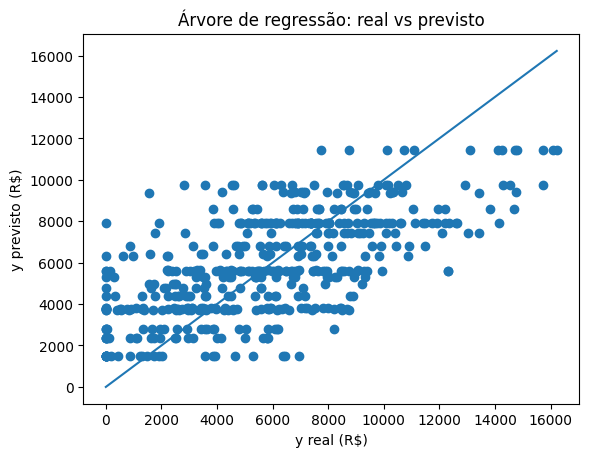

In [18]:
# O que este bloco faz:
# - Plota y real vs y previsto com a linha perfeita (y=x)
# - Ajuda a ver degraus e limites artificiais da árvore

plt.figure()
plt.scatter(y_test, pred)
plt.xlabel("y real (R$)")
plt.ylabel("y previsto (R$)")
plt.title("Árvore de regressão: real vs previsto")

m = min(y_test.min(), pred.min())
M = max(y_test.max(), pred.max())
plt.plot([m, M], [m, M])

plt.show()


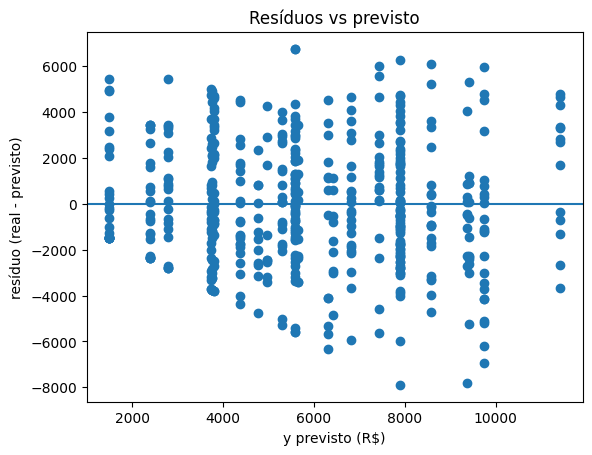

In [19]:
# O que este bloco faz:
# - Calcula resíduos (real - previsto)
# - Mostra se há padrão no erro (o que costuma existir em árvores)

resid = y_test - pred

plt.figure()
plt.scatter(pred, resid)
plt.axhline(0)
plt.xlabel("y previsto (R$)")
plt.ylabel("resíduo (real - previsto)")
plt.title("Resíduos vs previsto")
plt.show()

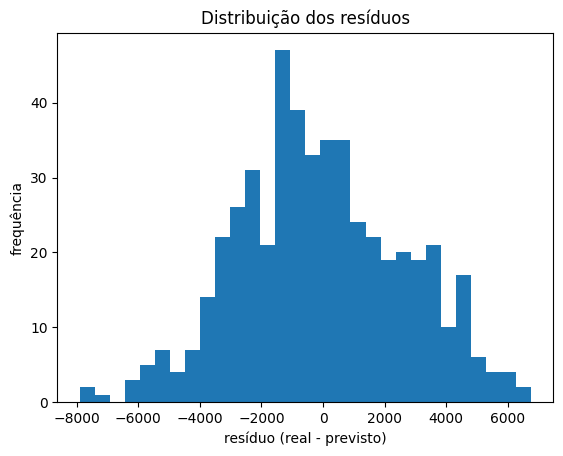

In [20]:
# O que este bloco faz:
# - Mostra o histograma dos resíduos
# - Ajuda a ver assimetria e caudas (erros grandes)

plt.figure()
plt.hist(resid, bins=30)
plt.xlabel("resíduo (real - previsto)")
plt.ylabel("frequência")
plt.title("Distribuição dos resíduos")
plt.show()

In [21]:
# O que este bloco faz:
# - Descobre a folha (região) onde cada ponto do teste caiu
# - Conta quantas folhas efetivas e quantos valores distintos foram previstos

prep = model.named_steps["prep"]
tree = model.named_steps["tree"]

Xt_test = prep.transform(X_test)
leaf_id = tree.apply(Xt_test)

n_folhas = len(np.unique(leaf_id))
n_patamares = len(np.unique(np.round(pred, 2)))

print(f"Folhas efetivas no teste: {n_folhas}")
print(f"Valores previstos distintos (patamares): {n_patamares}")

Folhas efetivas no teste: 24
Valores previstos distintos (patamares): 24


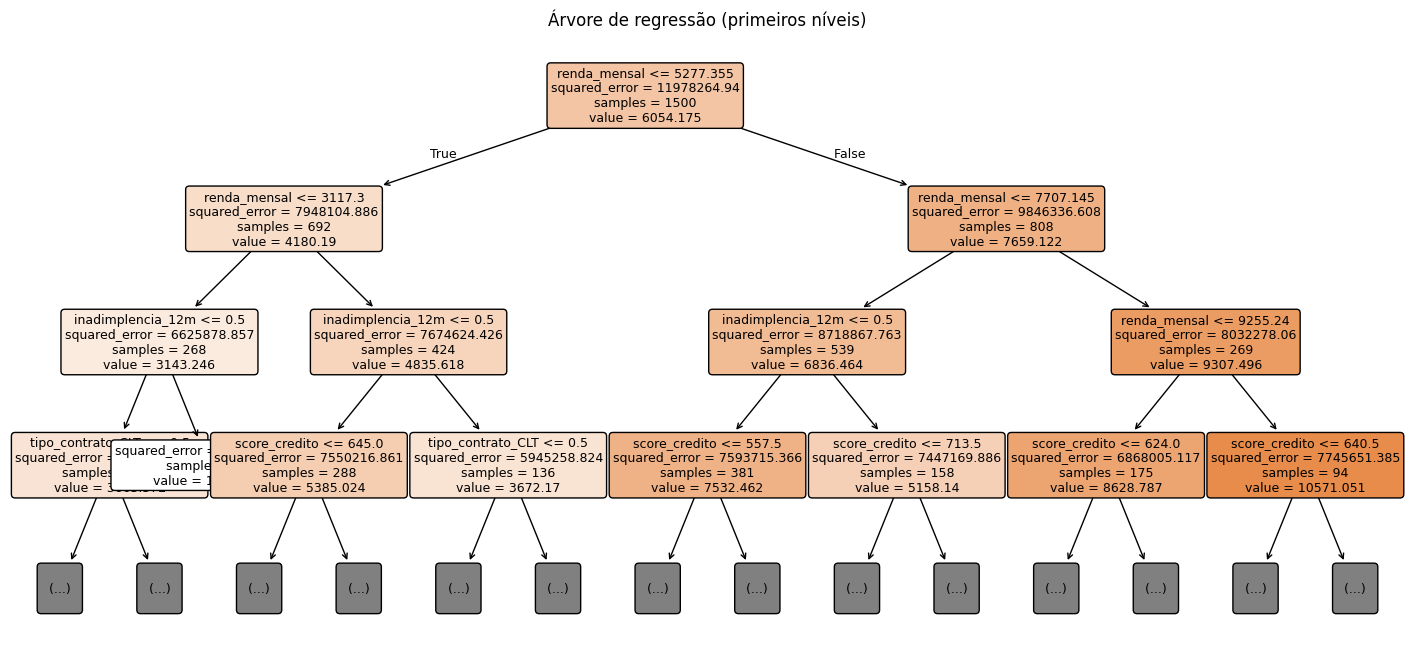

In [22]:
# O que este bloco faz:
# - Recupera os nomes das features depois do OneHotEncoder
# - Plota apenas os 3 primeiros níveis para manter legibilidade

ohe = prep.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_feature_names, np.array(num_cols)])

plt.figure(figsize=(18, 8))
plot_tree(
    tree,
    feature_names=feature_names,
    filled=True,
    max_depth=3,
    rounded=True,
    fontsize=9
)
plt.title("Árvore de regressão (primeiros níveis)")
plt.show()